In [1]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import math
import random


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor

from keras.models import Sequential
from keras.layers import Dense, LSTM, RNN, GRU, Dropout, Activation
from tensorflow.keras.datasets import imdb
from tensorflow.keras.layers import SimpleRNN, Embedding
from tensorflow.keras.preprocessing import sequence

from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import skew, kurtosis

In [2]:
df = pd.read_csv('./Ethereum Historical Data.csv')


In [3]:
def convert_to_number(price_str):
    price_str = price_str.replace(",", "")  # Remove any commas
    if 'K' in price_str:
        return float(price_str.replace('K', '')) * 1000
    elif 'M' in price_str:
        return float(price_str.replace('M', '')) * 1000000
    elif 'B' in price_str:
        return float(price_str.replace('B', '')) * 1000000000
    elif '%' in price_str:
        return float(price_str.replace('%', '')) / 100
    else:
        return float(price_str)

In [4]:
df['Date']  = pd.to_datetime(df['Date'])
df.reset_index(drop=True)
df.set_index('Date', inplace=True)
df['Vol.']   = df['Vol.'].apply(convert_to_number)
df.rename(columns={'Vol.': 'Vol'}, inplace=True)
df['Change %'] = df['Change %'].apply(convert_to_number)
df.rename(columns={'Change %': 'Change'}, inplace=True)
df['Price'] = df['Price'].apply(convert_to_number)
df['Open']  = df['Open'].apply(convert_to_number)
df['High']  = df['High'].apply(convert_to_number)
df['Low']   = df['Low'].apply(convert_to_number)

In [5]:
df.sort_index(ascending=True, inplace=True)


In [6]:
df.head()

,Price,Open,High,Low,Vol,Change
Date,,,,,,
2019-03-01,135.72,135.47,138.06,128.46,9730000.0,0.0018
2019-03-02,132.76,135.72,136.36,130.74,11290000.0,-0.0218
2019-03-03,131.01,132.77,168.42,129.05,10640000.0,-0.0132
2019-03-04,125.97,131.02,131.57,123.25,14110000.0,-0.0385
2019-03-05,136.82,125.97,141.11,125.44,16740000.0,0.0861


In [7]:
df['Year'] = df.index.year
df['Month'] = df.index.month
df['Day'] = df.index.day

In [8]:
train_size = 0.7
ratio ='7:3'

# model params
lstm_neurons = 20
rnn_neurons = 20
epochs = 100
batch_size = 4
loss = 'mae'
dropout = 0.25
optimizer = 'adam'

In [9]:
train_index = int(len(df)*train_size)

print('train index: ',train_index)


train index:  1344


In [10]:
df_train = df.iloc[:train_index]
df_test  = df[train_index:]
index_30 = random.randint(0, len(df) - 100)
index_60 =random.randint(0, len(df) - 100)
index_90 =random.randint(0, len(df) - 100)

df_30 = df.iloc[index_30: index_30+30]
df_60 = df.iloc[index_60: index_60+60]
df_90 = df.iloc[index_90: index_90+90]

date_range_30 = pd.date_range(start='2024-06-02', end='2024-07-02', periods=30)
date_range_60 = pd.date_range(start='2024-06-02', end='2024-08-01', periods=60)
date_range_90 = pd.date_range(start='2024-02-06', end='2024-08-31', periods=90)

df_30.index = date_range_30.date
df_60.index = date_range_60.date
df_90.index = date_range_90.date

print('df_train.shape: ',df_train.shape)
print('df_test.shape: ',df_test.shape)
print('df_30.shape: ',df_30.shape)
print('df_60.shape: ',df_60.shape)
print('df_90.shape: ',df_90.shape)

df_train.shape:  (1344, 9)
df_test.shape:  (576, 9)
df_30.shape:  (30, 9)
df_60.shape:  (60, 9)
df_90.shape:  (90, 9)


In [11]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_train_scaled = scaler.fit_transform(df_train)
df_test_scaled = scaler.transform(df_test)
df_30_scaled = scaler.transform(df_30)
df_60_scaled = scaler.transform(df_60)
df_90_scaled = scaler.transform(df_90)


df_train_scaled = pd.DataFrame(df_train_scaled, index=df_train.index, columns=df_train.columns)
df_test_scaled = pd.DataFrame(df_test_scaled, index=df_test.index, columns=df_test.columns)
df_30_scaled = pd.DataFrame(df_30_scaled,index =df_30.index,columns=df_30.columns)
df_60_scaled = pd.DataFrame(df_60_scaled,index =df_60.index,columns=df_60.columns)
df_90_scaled = pd.DataFrame(df_90_scaled,index =df_90.index,columns=df_90.columns)

In [12]:
X_train_scale = df_train_scaled.drop(columns=['Price'])
y_train_scale = df_train_scaled['Price']

X_test_scale  = df_test_scaled.drop(columns=['Price'])
y_test_scale  = df_test_scaled['Price']

X_30_scale = df_30_scaled.drop(columns=['Price'])
y_30_scale = df_30_scaled['Price']

X_60_scale = df_60_scaled.drop(columns=['Price'])
y_60_scale = df_60_scaled['Price']

X_90_scale = df_90_scaled.drop(columns=['Price'])
y_90_scale = df_90_scaled['Price']

In [13]:
print('X_train_scale shape: ',X_train_scale.shape)
print('y_train_scale shape: ',y_train_scale.shape)
print('\nX_test_scale shape: ',X_test_scale.shape)
print('y_test_scale shape: ',y_test_scale.shape)

X_train_scale shape:  (1344, 8)
y_train_scale shape:  (1344,)

X_test_scale shape:  (576, 8)
y_test_scale shape:  (576,)


### Stacking models ###

In [14]:
X_train_SM = X_train_scale.values.reshape((X_train_scale.shape[0], 1, X_train_scale.shape[1]))
y_train_SM  = y_train_scale.values

X_test_SM  = X_test_scale.values.reshape((X_test_scale.shape[0], 1, X_test_scale.shape[1]))
y_test_SM  = y_test_scale.values

X_30_SM = X_30_scale.values.reshape((X_30_scale.shape[0], 1, X_30_scale.shape[1]))
X_60_SM = X_60_scale.values.reshape((X_60_scale.shape[0], 1, X_60_scale.shape[1]))
X_90_SM = X_90_scale.values.reshape((X_90_scale.shape[0], 1, X_90_scale.shape[1]))

In [15]:
print('X_train_SM shape: ',X_train_SM.shape)
print('y_train_SM shape: ',y_train_SM.shape)
print('X_test_SM shape: ',X_test_SM.shape)
print('y_test_SM shape: ',y_test_SM.shape)

X_train_SM shape:  (1344, 1, 8)
y_train_SM shape:  (1344,)
X_test_SM shape:  (576, 1, 8)
y_test_SM shape:  (576,)


In [16]:
kf = KFold(n_splits=4,shuffle=False)

#### Base models ####

In [17]:
def build_GRU_model(input_shape, output_size, neurons=20, activ_func='linear',
                     dropout=0.25, loss='mae', optimizer='adam'):                     
    model = Sequential()

    model.add(GRU(neurons,  input_shape=input_shape))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [18]:
def build_lstm_model(input_shape, output_size, neurons=20, activ_func='linear',
                     dropout=0.25, loss='mae', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=input_shape))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    return model

In [19]:
base_model_GRU = build_GRU_model(
    (X_train_SM.shape[1],X_train_SM.shape[2]), output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)

In [20]:
base_model_LSTM = build_lstm_model(
    (X_train_SM.shape[1],X_train_SM.shape[2]), output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)

#### First base model (GRU) ####

In [21]:
X_train_GRU_stacking = pd.DataFrame()
y_30_GRU_stacking = {}
y_60_GRU_stacking = {}
y_90_GRU_stacking = {}
y_train_GRU_stacking = pd.DataFrame()
y_test_SM_GRU={}
i=0
for train_index, test_index in kf.split(X_train_SM):
    X_train_fold, X_test_fold = X_train_SM[train_index], X_train_SM[test_index]
    y_train_fold, y_test_fold = y_train_SM[train_index], y_train_SM[test_index]
    base_model_GRU.fit(X_train_fold, y_train_fold, epochs=10, batch_size=32, verbose=1)
    y_test_fold_predict = base_model_GRU.predict(X_test_fold)
    y_test_SM_GRU[f'y_test_SM_GRU_{i}'] = base_model_GRU.predict(X_test_SM)
    y_30_GRU_stacking[f'y_30_GRU_stacking_{i}'] = base_model_GRU.predict(X_30_SM)
    y_60_GRU_stacking[f'y_60_GRU_stacking_{i}'] = base_model_GRU.predict(X_60_SM)
    y_90_GRU_stacking[f'y_90_GRU_stacking_{i}'] = base_model_GRU.predict(X_90_SM)
    i+=1
    y_pred_fold_df = pd.DataFrame(y_test_fold_predict, columns=['Prediction'])
    y_test_fold_df = pd.DataFrame(y_test_fold, columns=['Prediction'])
    X_train_GRU_stacking = pd.concat([X_train_GRU_stacking, y_pred_fold_df], axis=0, ignore_index=True)
    y_train_GRU_stacking = pd.concat([y_train_GRU_stacking,y_test_fold_df], axis=0, ignore_index=True)

Epoch 1/10
32/32 [==============================] - 2s 4ms/step - loss: 0.2727
Epoch 2/10
32/32 [==============================] - 0s 3ms/step - loss: 0.1755
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.1285
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0896
Epoch 5/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0773
Epoch 6/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0647
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0578
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0572
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0514
Epoch 10/10
3/3 [==============================] - 0s 4ms/step
Epoch 1/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0485
Epoch 2/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0482
Epoch 3/10
32/32 [==============================] - 0s 5ms/step - lo

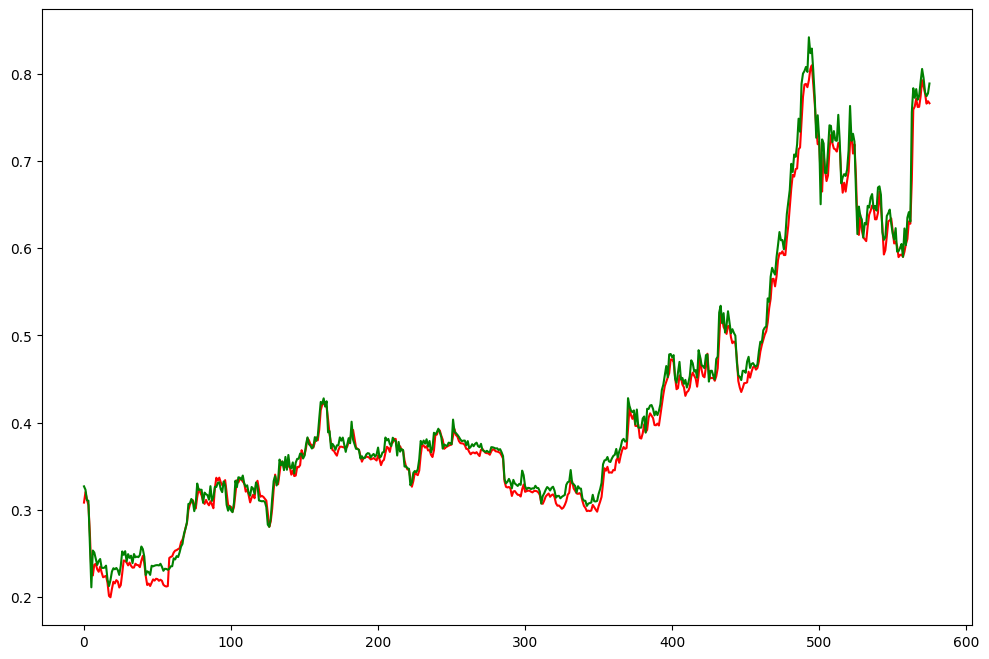

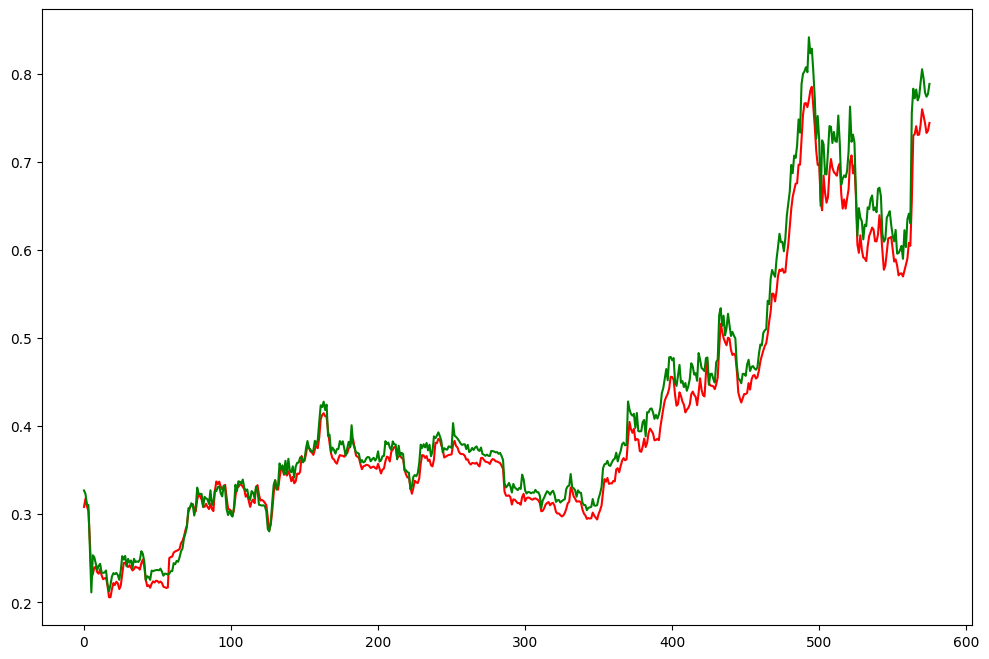

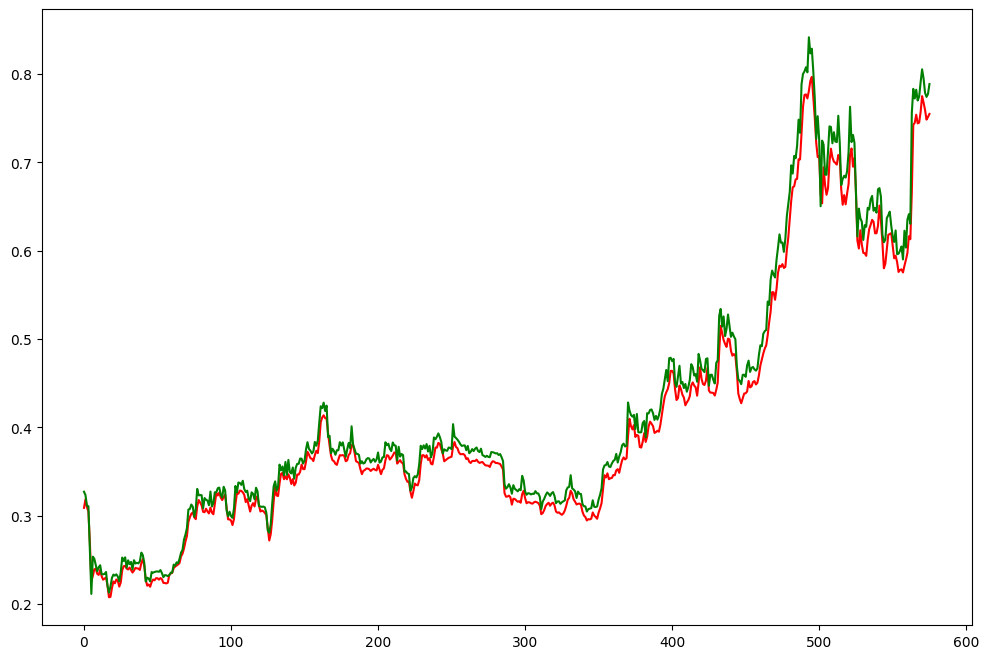

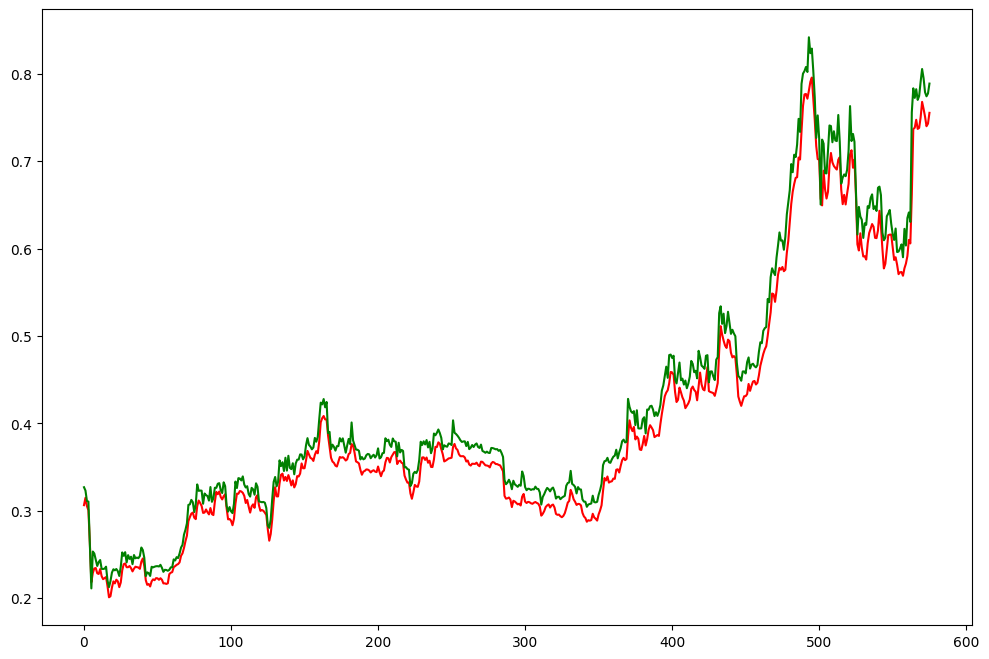

In [22]:
for key in y_test_SM_GRU:
    plt.figure(figsize=(12, 8))
    plt.plot(pd.DataFrame(y_test_SM_GRU[key]),color='red',label='Predicted test value')
    plt.plot(pd.DataFrame(y_test_SM), color ='green',label ='Actual test value' )
    plt.show()

In [23]:
num_elements = len(next(iter(y_test_SM_GRU.values())))
test_GRU_average = []
for i in range(num_elements):
    element_sum = sum(y_test_SM_GRU[key][i] for key in y_test_SM_GRU)
    test_GRU_average.append(element_sum / len(y_test_SM_GRU))
test_GRU_average = pd.DataFrame(test_GRU_average)

In [24]:
num_elements = len(next(iter(y_90_GRU_stacking.values())))
GRU_30_average =[]
GRU_60_average =[]
GRU_90_average =[]
for i in range(num_elements):
    if i <30:
        element_sum_30 = sum(y_30_GRU_stacking[key.replace('90','30')][i] for key in y_30_GRU_stacking)
        GRU_30_average.append(element_sum_30 / len(y_30_GRU_stacking))
    if i <60:
        element_sum_60 = sum(y_60_GRU_stacking[key.replace('90','60')][i] for key in y_60_GRU_stacking)
        GRU_60_average.append(element_sum_60 / len(y_60_GRU_stacking))
    element_sum_90 = sum(y_90_GRU_stacking[key][i] for key in y_90_GRU_stacking)
    GRU_90_average.append(element_sum_90 / len(y_90_GRU_stacking))
GRU_30_average = pd.DataFrame(GRU_30_average)
GRU_60_average = pd.DataFrame(GRU_60_average)
GRU_90_average = pd.DataFrame(GRU_90_average)

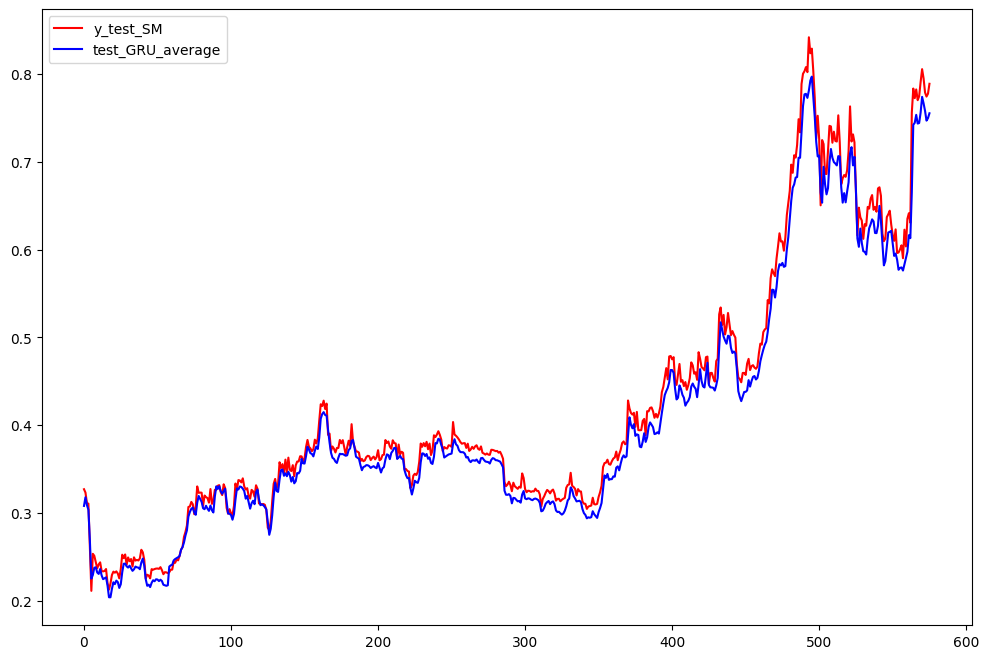

In [25]:
plt.figure(figsize=(12, 8))
plt.plot(pd.DataFrame(y_test_SM).index.to_list(), pd.DataFrame(y_test_SM), color='red', label='y_test_SM')
plt.plot(pd.DataFrame(y_test_SM).index.to_list(), pd.DataFrame(test_GRU_average), color='blue', label='test_GRU_average')
plt.legend()
plt.show()

#### Second base model (LSTM) ####

In [26]:
X_train_LSTM_stacking = pd.DataFrame()
y_30_LSTM_stacking = {}
y_60_LSTM_stacking = {}
y_90_LSTM_stacking = {}
y_train_LSTM_stacking = pd.DataFrame()
y_test_SM_LSTM={}
i=0
for train_index, test_index in kf.split(X_train_SM):
    X_train_fold, X_test_fold = X_train_SM[train_index], X_train_SM[test_index]
    y_train_fold, y_test_fold = y_train_SM[train_index], y_train_SM[test_index]
    base_model_LSTM.fit(X_train_fold, y_train_fold, epochs=10, batch_size=32, verbose=1)
    y_test_fold_predict = base_model_LSTM.predict(X_test_fold)
    y_test_SM_LSTM[f'y_test_SM_LSTM_{i}'] = base_model_LSTM.predict(X_test_SM)
    y_30_LSTM_stacking[f'y_30_LSTM_stacking_{i}'] = base_model_LSTM.predict(X_30_SM)
    y_60_LSTM_stacking[f'y_60_LSTM_stacking_{i}'] = base_model_LSTM.predict(X_60_SM)
    y_90_LSTM_stacking[f'y_90_LSTM_stacking_{i}'] = base_model_LSTM.predict(X_90_SM)
    i+=1
    y_pred_fold_df = pd.DataFrame(y_test_fold_predict, columns=['Prediction'])
    y_test_fold_df = pd.DataFrame(y_test_fold, columns=['Prediction'])
    X_train_LSTM_stacking = pd.concat([X_train_LSTM_stacking, y_pred_fold_df], axis=0, ignore_index=True)
    y_train_LSTM_stacking = pd.concat([y_train_LSTM_stacking,y_test_fold_df],axis=0,ignore_index=True)

Epoch 1/10
32/32 [==============================] - 2s 4ms/step - loss: 0.2858
Epoch 2/10
32/32 [==============================] - 0s 4ms/step - loss: 0.1495
Epoch 3/10
32/32 [==============================] - 0s 3ms/step - loss: 0.1100
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0766
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0592
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0562
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0565
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0511
Epoch 9/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0490
Epoch 10/10
3/3 [==============================] - 0s 4ms/step
Epoch 1/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0468
Epoch 2/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0452
Epoch 3/10
32/32 [==============================] - 0s 5ms/step - lo

In [27]:
num_elements = len(next(iter(y_test_SM_LSTM.values())))
test_LSTM_average = []

for i in range(num_elements):
    element_sum = sum(y_test_SM_LSTM[key][i] for key in y_test_SM_LSTM)
    test_LSTM_average.append(element_sum / len(y_test_SM_LSTM))

test_LSTM_average = pd.DataFrame(test_LSTM_average)

In [28]:
num_elements = len(next(iter(y_90_LSTM_stacking.values())))
LSTM_30_average =[]
LSTM_60_average =[]
LSTM_90_average =[]
for i in range(num_elements):
    if i <30:
        element_sum_30 = sum(y_30_LSTM_stacking[key.replace('90','30')][i] for key in y_30_LSTM_stacking)
        LSTM_30_average.append(element_sum_30 / len(y_30_LSTM_stacking))
    if i <60:
        element_sum_60 = sum(y_60_LSTM_stacking[key.replace('90','60')][i] for key in y_60_LSTM_stacking)
        LSTM_60_average.append(element_sum_60 / len(y_60_LSTM_stacking))
    element_sum_90 = sum(y_90_LSTM_stacking[key][i] for key in y_90_LSTM_stacking)
    LSTM_90_average.append(element_sum_90 / len(y_90_LSTM_stacking))
LSTM_30_average = pd.DataFrame(LSTM_30_average)
LSTM_60_average = pd.DataFrame(LSTM_60_average)
LSTM_90_average = pd.DataFrame(LSTM_90_average)

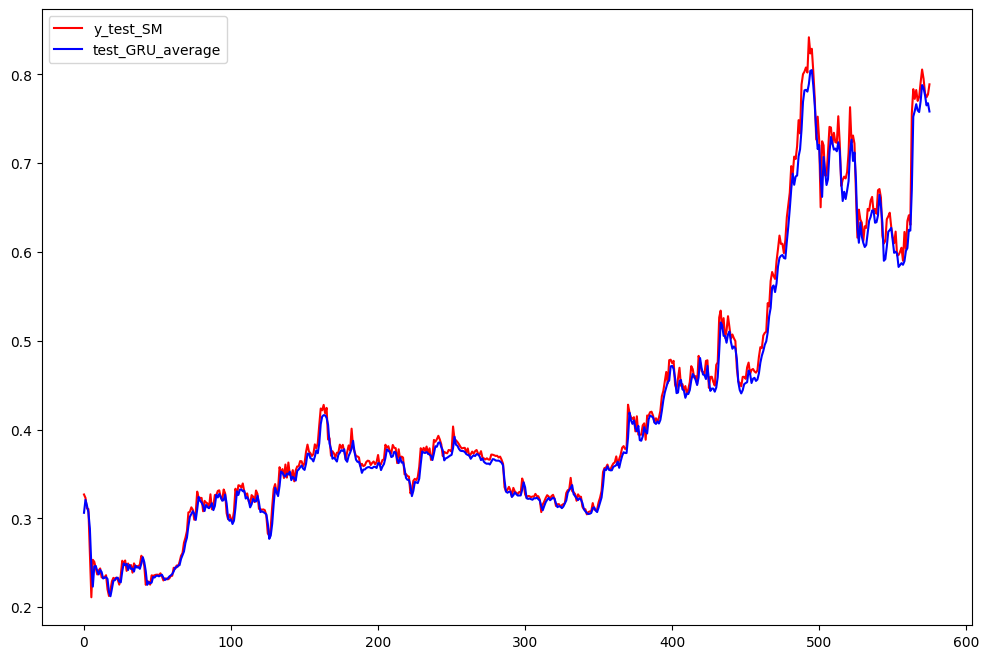

In [29]:
plt.figure(figsize=(12, 8))
plt.plot(pd.DataFrame(y_test_SM).index.to_list(), pd.DataFrame(y_test_SM), color='red', label='y_test_SM')
plt.plot(pd.DataFrame(y_test_SM).index.to_list(), pd.DataFrame(test_LSTM_average), color='blue', label='test_GRU_average')
plt.legend()
plt.show()

#### Train dataset for meta model ####

In [30]:
X_train_meta = pd.concat([X_train_GRU_stacking, X_train_LSTM_stacking], axis=1, ignore_index=True)
y_train_meta = y_train_GRU_stacking

#### Test dataset for meta model ####

In [31]:
y_test_meta = pd.concat([test_GRU_average,test_LSTM_average],axis=1, ignore_index=True)

#### Meta model training ####

In [32]:
X_train_meta = X_train_meta.values
y_train_meta = y_train_meta.values.reshape(-1)
X_test_meta  = y_test_meta.values
y_test_meta  = y_test_SM

X_30_meta = pd.concat([GRU_30_average,LSTM_30_average],axis=1, ignore_index=True)
X_60_meta = pd.concat([GRU_60_average,LSTM_60_average],axis=1, ignore_index=True)
X_90_meta = pd.concat([GRU_90_average,LSTM_90_average],axis=1, ignore_index=True)

In [33]:
print('X train shape of meta model: ', X_train_meta.shape)
print('y train shape of meta model: ',y_train_meta.shape)
print('X test shape of meta model', X_test_meta.shape)
print('y test shape of meta model',y_test_meta.shape)

X train shape of meta model:  (1344, 2)
y train shape of meta model:  (1344,)
X test shape of meta model (576, 2)
y test shape of meta model (576,)


In [34]:
meta_model = LinearRegression()
meta_model.fit(X_train_meta, y_train_meta)

LinearRegression()

In [35]:
pred_test_meta = meta_model.predict(X_test_meta)
pred_30_meta = meta_model.predict(X_30_meta)
pred_60_meta = meta_model.predict(X_60_meta)
pred_90_meta = meta_model.predict(X_90_meta)

In [36]:
mape = mean_absolute_percentage_error(y_test_meta, pred_test_meta)
mae = mean_absolute_error(y_test_meta,pred_test_meta)
mse = mean_squared_error(y_test_meta, pred_test_meta)
print(f'Mean Absolute Percentage Error: {mape}')
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {math.sqrt(mse)}')

Mean Absolute Percentage Error: 0.013407628170762005
Mean Absolute Error: 0.005708711473790656
Root Mean Squared Error: 0.008851597101233927


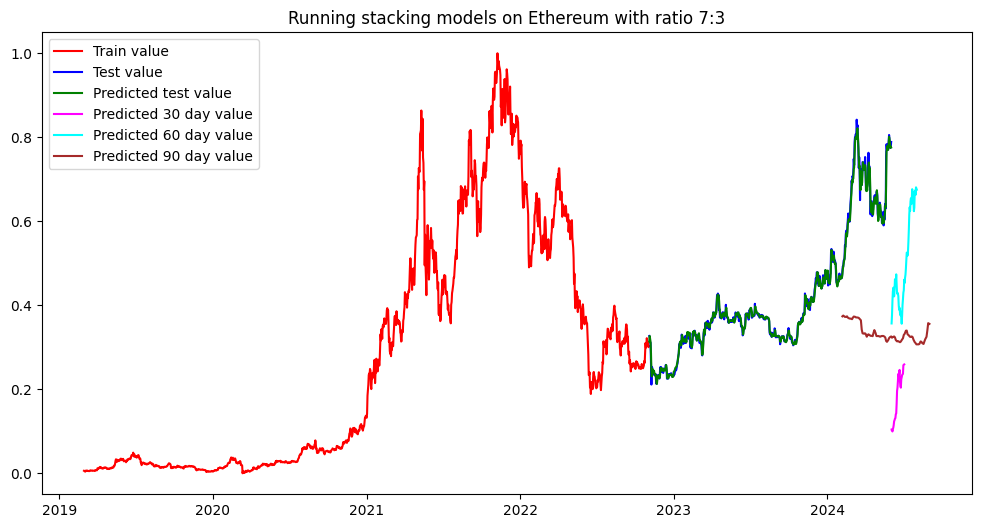

In [37]:
plt.figure(figsize=(12, 6))
plt.plot(pd.DataFrame(y_train_scale).index.to_list(),pd.DataFrame(y_train_SM),color='red',label='Train value')
plt.plot(pd.DataFrame(y_test_scale).index.to_list(), pd.DataFrame(y_test_SM), color='blue', label='Test value')
plt.plot(pd.DataFrame(y_test_scale).index.to_list(), pd.DataFrame(pred_test_meta), color='green', label='Predicted test value')
plt.plot(pd.DataFrame(y_30_scale).index.to_list(), pd.DataFrame(pred_30_meta), color='magenta', label='Predicted 30 day value')
plt.plot(pd.DataFrame(y_60_scale).index.to_list(), pd.DataFrame(pred_60_meta), color='cyan', label='Predicted 60 day value')
plt.plot(pd.DataFrame(y_90_scale).index.to_list(), pd.DataFrame(pred_90_meta), color='brown', label='Predicted 90 day value')
plt.title(f"Running stacking models on Ethereum with ratio {ratio}")
plt.legend()
plt.show()